In [8]:
import numpy as np

def admm(A, B, X, sparse_mat, para):
    pos_train = np.where(sparse_mat != 0)
    admm_iter = para["admm_iter"]
    admm_tol = para["admm_tol"]
    rho = para["rho"]
    
    X = sparse_mat.copy()
    Z = sparse_mat.copy()
    T = np.zeros(sparse_mat.shape)
    AB = np.matmul(A.T, B)
    obj = np.zeros(admm_iter)
    
    for k in range(admm_iter):
        X_old = X.copy()
        u, s, v = np.linalg.svd(Z - T / rho, full_matrices = False)
        vec = s - 1 / rho
        vec[vec < 0] = 0
        X = np.matmul(np.matmul(u, np.diag(vec)), v)
        
#         delta = np.linalg.norm(X - X_old, 'fro')
#         if delta < admm_tol:
#             break
        Z = X + (AB + T) / rho
        Z[pos_train] = sparse_mat[pos_train]
        T = T + rho * (X - Z)
        obj[k] = (np.sum(vec) - np.matrix.trace(np.matmul(np.matmul(A, Z), B.T))
                 + rho / 2 * np.linalg.norm(X - Z, 'fro') ** 2 
                  + np.matrix.trace(np.matmul(T.T, X - Z)))
        if k > 0 and abs(obj[k] - obj[k - 1]) < admm_tol:
            break
    return X

def LRMC(sparse_mat, dense_mat, rho, theta, maxiter, para):
    
    pos_train = np.where(sparse_mat != 0)
    pos_test = np.where((sparse_mat == 0) & (dense_mat != 0))
    binary_mat = sparse_mat.copy()
    binary_mat[pos_train] = 1
    
    X = sparse_mat.copy()
    rse = np.zeros(maxiter)
    
    for it in range(maxiter):
        u, s, v = np.linalg.svd(X, full_matrices = False)
        A = u[:, : theta].T
        B = v[: theta, :]
        X = admm(A, B, X, sparse_mat, para)
        rse[it] = (np.linalg.norm(X[pos_test] - dense_mat[pos_test], 2) 
                   / np.linalg.norm(dense_mat[pos_test], 2))
    return X, rse

In [4]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('../datasets/color-images/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('../datasets/color-images/{}.bmp'.format(name[0]))
sparse_mat = sparse_image[:, :, 1]
dense_mat = image[:, :, 1]

In [15]:
import time
import matplotlib.pyplot as plt

start = time.time()
rho = 0.005
maxiter = 50
theta = 10
para = {"admm_iter": 100, "admm_tol": 1, "rho": rho}
mat_hat, rse = LRMC(sparse_mat, dense_mat, rho, theta, maxiter, para)
end = time.time()

# plt.imshow(mat_hat)
# plt.title('The recovered image')
# plt.axis('off')
# plt.show()

print('Running time: %d seconds.'%(end - start))
print()
# print('Relative Squared Error (RSE) is {:.6}.'.format(rse_svt[-1]))

Running time: 23 seconds.



In [17]:
rse

array([0.15552816, 0.14426615, 0.1443437 , 0.14438807, 0.14439725,
       0.14439911, 0.14439954, 0.14439967, 0.14439972, 0.14439973,
       0.14439973, 0.14439973, 0.14439972, 0.14439972, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971,
       0.14439971, 0.14439971, 0.14439971, 0.14439971, 0.14439971])

Text(0.5, 1.0, 'Matrix completion using SVT.')

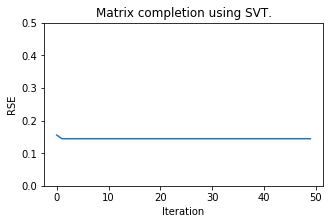

In [18]:
fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)
plt.plot(rse)
ax.set_ylim([0, 0.5])
plt.xlabel("Iteration")
plt.ylabel("RSE")
plt.title("Matrix completion using SVT.")